Los datos que usará google colab. La información está en:

1. new_base_dir almacena el path de la BD reducida con la que se entrenará en este ejemplo. Dentro debe tener tres carpetas: train, test y validation y dentro de cada una, dos carpetas: Manga y Comic


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!unzip '/content/drive/MyDrive/manga_comic.zip'

Se han truncado las últimas 5000 líneas del flujo de salida.
 extracting: manga_comic/train/Comic/1848.png  
 extracting: manga_comic/train/Comic/1849.png  
  inflating: manga_comic/train/Comic/185.png  
 extracting: manga_comic/train/Comic/1850.png  
 extracting: manga_comic/train/Comic/1851.png  
 extracting: manga_comic/train/Comic/1852.png  
 extracting: manga_comic/train/Comic/1853.png  
 extracting: manga_comic/train/Comic/1854.png  
 extracting: manga_comic/train/Comic/1855.png  
 extracting: manga_comic/train/Comic/1856.png  
 extracting: manga_comic/train/Comic/1857.png  
 extracting: manga_comic/train/Comic/1858.png  
 extracting: manga_comic/train/Comic/1859.png  
 extracting: manga_comic/train/Comic/186.png  
 extracting: manga_comic/train/Comic/1860.png  
  inflating: manga_comic/train/Comic/1861.png  
 extracting: manga_comic/train/Comic/1862.png  
 extracting: manga_comic/train/Comic/1863.png  
 extracting: manga_comic/train/Comic/1864.png  
 extracting: manga_comic/trai

In [ ]:
from IPython.display import Image #Librería para visualizar imágenes en Jupyter
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

conv_base  = keras.applications.inception_resnet_v2.InceptionResNetV2(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False


new_base_dir=r"manga_comic"
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

Visualizar una imagen

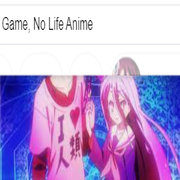

In [ ]:
display(Image(filename="manga_comic/train/Manga/1005.png"))

Definición de la red neuronal de 1 neurona para imagénes de 180x180 píxeles

Hiperparámetros para el entrenamiento y medición de desempeño

Convierte la información de la imagen de píxeles en un tensor numérico de punto flotante y ajusta el tamaño de la imagen porque todas tienen diferente resolución

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir+"/"+"train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir+"/"+"validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir+"/"+"test",
    image_size=(180, 180),
    batch_size=32)

Found 3942 files belonging to 2 classes.
Found 1990 files belonging to 2 classes.
Found 2649 files belonging to 2 classes.


Extrayendo las características de los conjuntos de entrenamiento, validación y prueba con sus etiquetas

In [ ]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        all_features.append(images)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

print(test_features.shape)
print(test_labels.shape)

(2649, 180, 180, 3)
(2649,)


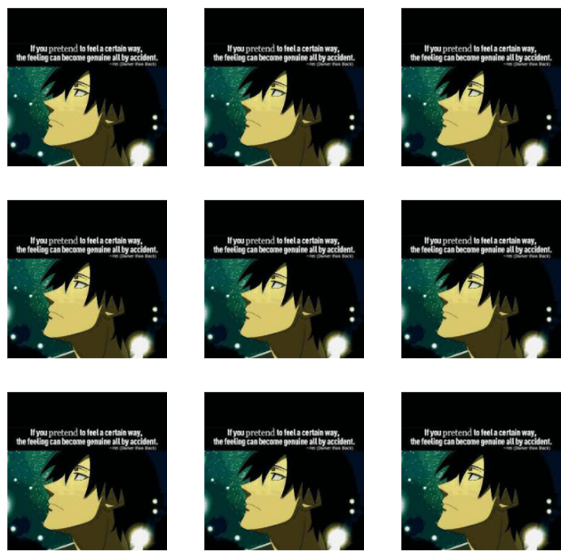

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [ ]:
conv_base.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_406 (Conv2D)            (None, None, None,   864         ['input_3[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization_406 (Batch  (None, None, None,   96         ['conv2d_406[0][0]']             
 Normalization)                 32)                                             

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.inception_resnet_v2.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(512, kernel_regularizer=keras.regularizers.l2(0.01),
                activity_regularizer=keras.regularizers.l2(0.01))(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation="sigmoid", kernel_regularizer=keras.regularizers.l2(0.01),
                activity_regularizer=keras.regularizers.l2(0.01))(x)
model = keras.Model(inputs, outputs)
model.summary()

model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              tf.keras.optimizers.Adam(learning_rate=0.1)
              metrics=["accuracy"])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 180, 180, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 180, 180, 3)      0         
 bda)                                                            
                                                                 
 inception_resnet_v2 (Functi  (None, None, None, 1536)  54336736 
 onal)                                                           
                                                           

Fase de entrenamiento 

In [ ]:
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset)

Epoch 1/50
124/124 [==============================] - 55s 231ms/step - loss: 13.5073 - accuracy: 0.7605 - val_loss: 14.0529 - val_accuracy: 0.8452
Epoch 2/50
124/124 [==============================] - 26s 207ms/step - loss: 12.7818 - accuracy: 0.8227 - val_loss: 12.9325 - val_accuracy: 0.8668
Epoch 3/50
124/124 [==============================] - 26s 207ms/step - loss: 12.3377 - accuracy: 0.8460 - val_loss: 12.4960 - val_accuracy: 0.8236
Epoch 4/50
124/124 [==============================] - 26s 208ms/step - loss: 11.9417 - accuracy: 0.8615 - val_loss: 12.0426 - val_accuracy: 0.8643
Epoch 5/50
124/124 [==============================] - 26s 209ms/step - loss: 11.6072 - accuracy: 0.8645 - val_loss: 11.6980 - val_accuracy: 0.8698
Epoch 6/50
124/124 [==============================] - 26s 209ms/step - loss: 11.3026 - accuracy: 0.8729 - val_loss: 11.3591 - val_accuracy: 0.8874
Epoch 7/50
124/124 [==============================] - 26s 210ms/step - loss: 11.0031 - accuracy: 0.8792 - val_loss: 11

Visualización de la pérdidad y el accuracy tanto para los datos de entrenamiento como para los datos de validación y así detectar si hay overfitting

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Matriz de confusión

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
test_predictions = model.predict(test_features)
cm = confusion_matrix(test_labels, test_predictions > 0.5)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Cálculo de la exactitud (en inglés, *accurracy*)

In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(test_labels, test_predictions > 0.5))

Ejercicio:
----------
1. Desarrollar un modelo que tenga la mejor exactitud (en inglés, *accurracy*) posible en el conjunto de prueba (en inglés, *test*). Para lograrlo, hay que hacer un entrenamiento sin sobreajustar (en inglés, *overfit*)